In [ ]:
import dataclasses as dc
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
import torch.nn.functional as F
from typing import Tuple

In [ ]:
@dc.dataclass
class Trajectory:
    """
    x: Lies in [-1, 1]
    t: Lies in [ 0, 1]. The start time is always 0 and  end time is always 1.
    """
    x: Tensor  # dtype=float, shape=(N,)
    t: Tensor  # dtype=float, shape=(N,)

In [ ]:
def CubicHermiteInterpolation(
    seed_trajectory: Trajectory,
    initial_slope: float = None,
    final_slope: float = None,
    initial_double_derivative: float = None,
    final_double_derivative: float = None,
    num_points: int = 100,
) -> Trajectory:
    """
    Cubic Hermite interpolation.
    Copied and modified from https://stackoverflow.com/a/64872885/1814274
    """
    def hermite_polynomial(t):
        t_powers = t[None, :] ** torch.arange(4, device=t.device)[:, None]
        coefficient_matrix = torch.tensor([
            [1, 0, -3,  2],
            [0, 1, -2,  1],
            [0, 0,  3, -2],
            [0, 0, -1,  1],
        ], dtype=t.dtype, device=t.device)
        return coefficient_matrix @ t_powers

    seed_x, seed_t = seed_trajectory.x, seed_trajectory.t
    interpolated_t = torch.linspace(seed_trajectory.t[0], seed_trajectory.t[-1], num_points)
    slopes = (seed_x[1:] - seed_x[:-1]) / (seed_t[1:] - seed_t[:-1])
    
    if initial_slope is not None:
        slopes = torch.cat([torch.tensor([initial_slope], device=slopes.device), (slopes[1:] + slopes[:-1]) / 2, slopes[[-1]]])
    else:
        slopes = torch.cat([slopes[[0]], (slopes[1:] + slopes[:-1]) / 2, slopes[[-1]]])
    
    if final_slope is not None:
        slopes[-1] = final_slope

    if initial_double_derivative is not None:
        slopes[0] = initial_double_derivative * (seed_t[1] - seed_t[0]) / 2 + slopes[0]
    
    if final_double_derivative is not None:
        slopes[-1] = final_double_derivative * (seed_t[-1] - seed_t[-2]) / 2 + slopes[-1]

    indices = torch.searchsorted(seed_t[1:], interpolated_t)
    Δt = (seed_t[indices + 1] - seed_t[indices])
    hermite_values = hermite_polynomial((interpolated_t - seed_t[indices]) / Δt)
    interpolated_x = (
        hermite_values[0] * seed_x[indices + 0] + 
        hermite_values[1] * slopes[indices + 0] * Δt + 
        hermite_values[2] * seed_x[indices + 1] + 
        hermite_values[3] * slopes[indices + 1] * Δt
    )
    return Trajectory(interpolated_x, interpolated_t)

def JoinTrajectories(traj1: Trajectory, traj2: Trajectory) -> Trajectory:
    """
    Concatenate two trajectories.
    """
    x = torch.cat([torch.tensor(traj1.x), torch.tensor(traj2.x)])
    t = torch.cat([torch.tensor(traj1.t), torch.tensor(traj2.t)])
    return Trajectory(x=x, t=t)

In [278]:
def demonstration_traj_right() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = Trajectory(x=torch.zeros(25), t=torch.linspace(0, 0.25, 25))
    piece_2 = CubicHermiteInterpolation(
        Trajectory(
            x=torch.tensor([0.00, 0.62, 0.75, 0.5]),
            t=torch.tensor([0.25, 0.50, 0.75, 1.0])
        ),
        initial_slope=0.0,
        initial_double_derivative=0.0,
        final_slope=-1,
        final_double_derivative=0.0,
    )
    return JoinTrajectories(piece_1, piece_2)

def demonstration_traj_left() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = Trajectory(x=torch.zeros(25), t=torch.linspace(0, 0.25, 25))
    piece_2 = CubicHermiteInterpolation(
        Trajectory(
            x=torch.tensor([0.00, -0.62, -0.75, -0.5]),
            t=torch.tensor([0.25,  0.50,  0.75,  1.0])
        ),
        initial_slope=0.0,
        initial_double_derivative=0.0,
        final_slope=1,
        final_double_derivative=0.0,
    )
    return JoinTrajectories(piece_1, piece_2)

/tmp/ipykernel_289898/1616676832.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.cat([torch.tensor(traj1.x), torch.tensor(traj2.x)])
/tmp/ipykernel_289898/1616676832.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.cat([torch.tensor(traj1.t), torch.tensor(traj2.t)])


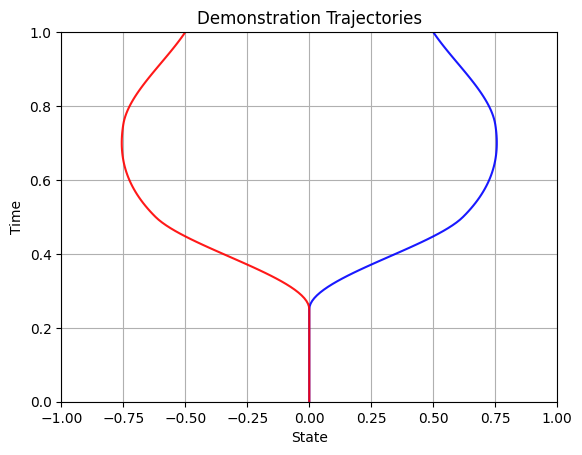

In [279]:
"""
Plot demonstration trajectory on x-y plane where x axis is the state in [-1, 1]
and y axis is the time in [0, 1].
"""
traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()
plt.plot(traj_right.x, traj_right.t, color='blue', alpha=0.9)
plt.plot(traj_left.x, traj_left.t, color='red', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('State')
plt.ylabel('Time')
plt.title('Demonstration Trajectories')
plt.grid(True)
plt.show()